In [70]:
from data_pipeline.modular_data_extraction import create_data_packages
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms
from data_pipeline.ukb_data_extractor import UkbDataExtractor
import data_pipeline.data_processing_utils as dpu

from data_pipeline.odir_5k_data_extractor import ODIR5KDataExtractor
from data_pipeline.rfmid_data_extractor import RFMiDDataExtractor
from data_pipeline.rfmid2_data_extractor import RFMiD2DataExtractor
from data_pipeline.ukb_data_extractor import UkbDataExtractor
from data_pipeline.rips_data_extractor import RIPSDataExtractor
from data_pipeline.ses_data_extractor import SESDataExtractor
from data_pipeline.one_thousand_images_data_extractor import OneThousandImagesDataExtractor

from data_pipeline.data_processing_utils import standardize_labels
from data_pipeline.data_processing_utils import create_one_hot_encoder
import data_pipeline.data_processing_utils as dpu
import data_pipeline.data_splitting_utils as dsu



from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
import numpy as np

from convert_user_inputs import convert_user_input, create_datasets
from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
from datetime import datetime
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd



In [71]:
model_key = 'resnet18'
transform_type = 'ben'
batch_size = 16
lr = 0.00004614948033730265
epochs = 30
dataset_name = '2024-02-23-13-31-39'
dataset_path = f'datasets/{dataset_name}'

In [72]:
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophie or Cone-rod Dystrophie", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease"])

In [73]:
model_key = 'resnet18'
transform_type = 'ben'
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)

In [74]:
ukb_database_path = 'databases/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx'
ukb_data_path ='databases/ird_dataset/export_heyex_original_dataset_03/DICOM'
ukb_extractor = UkbDataExtractor(database_path=ukb_data_path, label_path=ukb_database_path)

odir5k_data_extractor = ODIR5KDataExtractor(database_path='databases/ODIR-5K/full_df.csv', database_test_images_path='databases/ODIR-5K/Testing Images',
                                                database_train_images_path='databases/ODIR-5K/Training Images')

rfmid_train_data_extractor = RFMiDDataExtractor(database_path='databases/RFMiD/Training_Set/RFMiD_Training_Labels.csv',
                                            data_path='databases/RFMiD/Training_Set/Training', file_format='png')

rfmid_validation_datae_xtractor = RFMiDDataExtractor(database_path='databases/RFMiD/Evaluation_Set/RFMiD_Validation_Labels.csv',
                                            data_path='databases/RFMiD/Evaluation_Set/Validation', file_format='png')

rfmid_test_data_extractor = RFMiDDataExtractor(database_path='databases/RFMiD/Test_Set/RFMiD_Testing_Labels.csv',
                                                data_path='databases/RFMiD/Test_Set/Test', file_format='png')

rfmid2_train_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Training_set/RFMiD_2_Training_labels.csv',
                                                    data_path='databases/RFMiD2_0/Training_set')
rfmid2_validation_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Validation_set/RFMiD_2_Validation_labels.csv',
                                                            data_path='databases/RFMiD2_0/Validation_set')

rfmid2_test_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Test_set/RFMiD_2_Testing_labels.csv',
                                                        data_path='databases/RFMiD2_0/Test_set')


one_thousand_images_data_extractor = OneThousandImagesDataExtractor(database_path='databases/1000images/')

rips_data_extractor = RIPSDataExtractor(database_path='databases/RIPS/Original')

ses_data_extractor = SESDataExtractor(database_path='databases/SES/')


In [75]:
#create the data extraction list
default_data_extractors = [odir5k_data_extractor, rfmid_train_data_extractor, rfmid_validation_datae_xtractor, rfmid_test_data_extractor,
                    rfmid2_train_data_extractor, rfmid2_validation_data_extractor, rfmid2_test_data_extractor,
                    one_thousand_images_data_extractor, rips_data_extractor, ses_data_extractor]

dicom_data_extractors = [ukb_extractor]

data_extractors = default_data_extractors + dicom_data_extractors


In [76]:
#extract the data
for data_extractor in data_extractors:
    data_extractor.extract()

#standardize the data
#get the labels of the data
datasets_labels = []
for data_extractor in data_extractors:
    datasets_labels.append(data_extractor.get_labels())
#flatten
labels = []
for dataset_labels in datasets_labels:
    labels.extend(dataset_labels)
#concatenate the labels
labels = np.concatenate(labels)
#drop the None values
labels = labels[labels != None]

In [77]:
print(set(labels))

{'Central Serous Retinopathy', 'dry age-related macular degeneration', 'retinal pigmentation', 'Retinal Tears', 'Macular Hole', 'low image quality', 'peripapillary atrophy', 'pigment epithelium proliferation', 'depigmentation of the retinal pigment epithelium', 'diffuse chorioretinal atrophy', 'Netzhautdystrophie', 'suspected retinal vascular sheathing', 'suspicious diabetic retinopathy', 'Hemorrhagic Pigment Epithelial Detachment', 'macular pigmentation disorder', 'Cotton-Wool Spots', 'Retinitis', 'Cysticercosis', 'old branch retinal vein occlusion', 'Fundus neoplasm', 'Yellow-white spots-flecks', 'Laser Spots', 'severe nonproliferative retinopathy', 'Drusen', 'retinochoroidal coloboma', 'Blur fundus with suspected PDR', 'idiopathic choroidal neovascularization', 'Parafoveal Telangiectasia', 'Peripheral retinal degeneration and break', 'VKH disease', 'Optociliary Shunt', 'Vessel tortuosity', 'Chorioretinitis', 'Branch Retinal Vein Occlusion', 'cataract', 'OPDM', 'central retinal arter

In [78]:
not_summarize_set = set(RFMiD2DataExtractor.abbreviation_map.values())
ukb_label_mapping_dict = {'Morbus Best': 'Best Disease', 'Morbus Stargardt': 'Stargardt Disease', 'Retinitis pigmentosa': 'Retinitis Pigmentosa'}
label_standertizer = standardize_labels(labels = labels, not_summarize_set=not_summarize_set)
label_standertizer.update(ukb_label_mapping_dict)

In [79]:
#value count the labels
label_counts = pd.Series(labels).value_counts()
#get the median label count
median_label_count = label_counts.median()
label_instance_limit = int((max(label_counts) - median_label_count) // 4)
#balance the labels
#find the over represented labels
for labels,extractor in zip(datasets_labels, data_extractors):
    #find the over represented labels
    #replace none with empty string
    over_represented_labels_idxs, _, _ = dpu.find_over_represented_samples(file_paths=extractor.get_file_paths(), labels=labels,
                                                                            max_samples_per_class=label_instance_limit)
    #remove the over represented labels
    #conver the indexes to a boolean array
    over_represented_labels_series = np.isin(np.arange(len(labels)), over_represented_labels_idxs)
    extractor.extracted_data = extractor.extracted_data[~over_represented_labels_series]

In [80]:
#split the data stratified by the labels
train_portion = 0.7
val_portion = 0.1
test_portion = 0.2
split_portions = [train_portion, val_portion, test_portion]

In [81]:
for data_extractor in data_extractors:
    data_extractor.split_extracted_data(split_portions = split_portions, stratify=True)

In [82]:
print(data_extractors[1].get_current_split())
splits = []
for data_extractor in data_extractors:
    splits.extend(data_extractor.get_current_split())

[<data_pipeline.data_package.DataPackage object at 0x7f7ab884c410>, <data_pipeline.data_package.DataPackage object at 0x7f7ab8556890>, <data_pipeline.data_package.DataPackage object at 0x7f7ab89d4750>]


In [83]:
lambda_strip = lambda x: x.strip() if isinstance(x, str) else x
label_translation = lambda x: label_standertizer.get(x, x)
for i, split in enumerate(splits):
    #strip trailing and leading whitespaces
    #split.labels = np.vectorize(lambda_strip)(split.labels)
    split.labels = np.vectorize(label_translation)(split.labels)


In [84]:
#get all the labels
all_labels = []
for split in splits:
    all_labels.extend(split.labels)
#create set of all labels
all_labels = np.concatenate(all_labels)
#filter out the None values
all_labels = all_labels[all_labels != None]
all_labels = np.unique(all_labels)
print(all_labels)

[' Albinismus' 'Achromatopsie' 'Age-related Macular Degeneration'
 'Anterior Ischemic Optic Neuropathy' 'Asteroid Hyalosis' 'BBS' 'BRVO'
 'Best Disease' 'Bietti crystalline dystrophy'
 'Blur fundus with suspected PDR' 'Blur fundus without PDR'
 'Branch Retinal Artery Occlusion' 'Branch Retinal Vein Occlusion' 'CNV'
 'CRVO' 'CSCR' 'CSNB' 'Central Retinal Artery Occlusion'
 'Central Retinal Vein Occlusion' 'Central Serous Retinopathy'
 'Chorioideremie' 'Chorioretinitis' 'Choroidal Folds' 'Collateral'
 'Coloboma' 'Cone Dystrophie or Cone-rod Dystrophie'
 'Congenital disc abnormality' 'Cotton-Wool Spots' 'Cysticercosis'
 'Cystoid Macular Edema' 'DR1' 'DR2' 'DR3' 'Diabetic Retinopathy'
 'Disc swelling and elevation' 'Dragged Disc' 'Drusen' 'ERM'
 'Epiretinal Membrane' 'Exudation' 'Fibrosis' 'Fundus albipunctatus'
 'Fundus neoplasm' 'Giant Retinal Tear'
 'Hemorrhagic Pigment Epithelial Detachment' 'Hemorrhagic Retinopathy'
 'LHON' 'Large optic cup' 'Laser Scars' 'Leber congenital amaurosis' 

In [85]:
label_encoder = dpu.create_one_hot_encoder(unique_labels=labels_to_encode)

In [86]:
for split in splits:
    split.labels = dpu.encode_multistring_labels(split.labels, label_encoder)

In [87]:
to_encode = np.array(['glaucoma', 'Normal']).reshape(-1, 1)
dpu.encode_multistring_labels(to_encode, label_encoder)

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [88]:
print(label_encoder.categories_)

[array(['Age-related Macular Degeneration', 'Best Disease',
       'Bietti crystalline dystrophy', 'cataract',
       'Cone Dystrophie or Cone-rod Dystrophie', 'Diabetic Retinopathy',
       'glaucoma', 'Maculopathy', 'Myopia', 'Normal',
       'Retinitis Pigmentosa', 'Stargardt Disease'], dtype=object)]


In [89]:
#find out which datapoints have a full 0 label
for split in splits:
    labels = split.get_labels()
    no_zero_labels = np.sum(labels, axis=1) != 0
    #print len false values
    print('n filtered', len(no_zero_labels) - np.sum(no_zero_labels), 'out of', len(no_zero_labels))
    #throw away the datapoints with no labels
    split.labels = labels[no_zero_labels]
    split.data = split.data[no_zero_labels]


n filtered 1644 out of 2978
n filtered 222 out of 425
n filtered 473 out of 850
n filtered 671 out of 1341
n filtered 103 out of 200
n filtered 189 out of 379
n filtered 215 out of 444
n filtered 34 out of 66
n filtered 64 out of 130
n filtered 225 out of 448
n filtered 33 out of 64
n filtered 63 out of 128
n filtered 178 out of 310
n filtered 31 out of 51
n filtered 56 out of 94
n filtered 59 out of 106
n filtered 9 out of 15
n filtered 21 out of 35
n filtered 63 out of 104
n filtered 10 out of 16
n filtered 16 out of 29
n filtered 561 out of 699
n filtered 81 out of 100
n filtered 162 out of 201
n filtered 0 out of 60
n filtered 0 out of 30
n filtered 0 out of 30
n filtered 2 out of 87
n filtered 0 out of 12
n filtered 0 out of 26
n filtered 733 out of 1427
n filtered 103 out of 204
n filtered 224 out of 407


In [90]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
dicom_file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
default_file_reader = lambda x: Image.open(x).convert('RGB')


In [91]:
len(default_data_extractors[0].get_current_split()[0].get_labels())

1334

In [92]:
train_datasets, val_datasets, test_datasets = [], [], []
for data_extractor in default_data_extractors:
    #get the extractors data splits
    extractors_split = data_extractor.get_current_split()
    train_dataset = NpDataset(file_paths=extractors_split[0].get_data()[:,1], labels=extractors_split[0].get_labels(), file_reader=default_file_reader, transform=transform)
    val_dataset = NpDataset(file_paths=extractors_split[1].get_data()[:,1], labels=extractors_split[1].get_labels(), file_reader=default_file_reader, transform=transform)
    test_dataset = NpDataset(file_paths=extractors_split[2].get_data()[:,1], labels=extractors_split[2].get_labels(), file_reader=default_file_reader, transform=transform)
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)

#do the same for the dicom data
for data_extractor in dicom_data_extractors:
    #get the extractors data splits
    extractors_split = data_extractor.get_current_split()
    train_dataset = NpDataset(file_paths=extractors_split[0].get_data()[:,1], labels=extractors_split[0].get_labels(), file_reader=dicom_file_reader, transform=transform)
    val_dataset = NpDataset(file_paths=extractors_split[1].get_data()[:,1], labels=extractors_split[1].get_labels(), file_reader=dicom_file_reader, transform=transform)
    test_dataset = NpDataset(file_paths=extractors_split[2].get_data()[:,1], labels=extractors_split[2].get_labels(), file_reader=dicom_file_reader, transform=transform)
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)


In [93]:
#concat the datasets
train_dataset = ConcatDataset(train_datasets)
validation_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

#create data loaders
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [94]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))


3653 557 1041


In [95]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))


/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [96]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [97]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [98]:
#train the model
best_model_save_folder = f'ukb_fine_tuned_models/{dataset_name}/{model_key}/best_model_{transform_type}'
best_model_save_path = f'{best_model_save_folder}/best_model.pt'
os.makedirs(best_model_save_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
progress_bar = tqdm.tqdm(range(epochs))
validation_loss_criterion = nn.BCEWithLogitsLoss()
validation_losses = []
best_validation_loss = np.inf
#move the model to the device
model.to(device)
#only run training if no model has been saved yet
if not os.path.exists(best_model_save_path):
    for epoch in progress_bar:
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            validaton_outputs = []
            validaton_labels = []
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                validaton_outputs.append(outputs)
                validaton_labels.append(labels)
            #concatenate the outputs and labels
            validaton_outputs = torch.cat(validaton_outputs, dim=0)
            validaton_labels = torch.cat(validaton_labels, dim=0)
            loss_validation = validation_loss_criterion(validaton_outputs, validaton_labels).item()
            if is_min(loss_validation, best_validation_loss):
                best_validation_loss = loss_validation
                torch.save(model.state_dict(), best_model_save_path)
            validation_losses.append(loss_validation)
            #update the progress bar
            progress_bar.set_postfix({'Loss validation': loss_validation, 'best validation loss': min(validation_losses)})
        

  0%|          | 0/30 [06:30<?, ?it/s]


In [ ]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

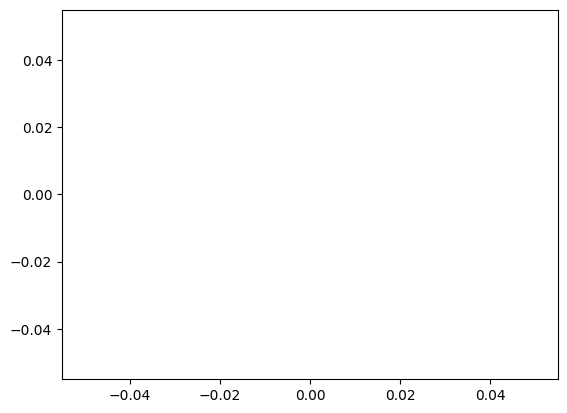

In [ ]:
plt.plot(validation_losses)

In [ ]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

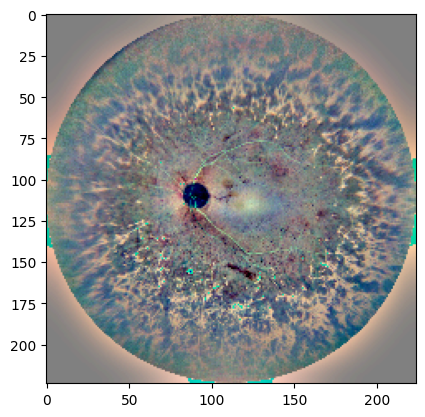

In [ ]:
import random
from torchvision.transforms.functional import to_pil_image
for data, label in val_dataset:
    #plot the image
    if random.random() < 0.5:
        plt.imshow(to_pil_image(data))
        plt.show()
        break

In [ ]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(labels_to_encode)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', labels_to_encode[i], 'at', best_thresholds[i], 'with a score of', best_score)
#save the best thresholds
model_config = {
    'best_thresholds': best_thresholds
}

best_thresholds = torch.Tensor(best_thresholds)



In [ ]:
print('Best thresholds:', best_thresholds)
print(best_thresholds)

Best thresholds: tensor([0.3300, 0.0700, 0.0000, 0.0000, 0.0000, 0.0700, 0.0000, 0.0300, 0.1300,
        0.5100, 0.5100, 0.8800])
tensor([0.3300, 0.0700, 0.0000, 0.0000, 0.0000, 0.0700, 0.0000, 0.0300, 0.1300,
        0.5100, 0.5100, 0.8800])


In [ ]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

In [ ]:
translations = set(label_standertizer.values())
print('translations', translations)
#check if all the labels to encode are in the translations
for label in labels_to_encode:
    if label not in translations:
        print('Label', label, 'not in translations')
print(label_standertizer.get('glaucoma'))

translations {'Age-related Macular Degeneration', 'Retinitis Pigmentosa', 'Maculopathy', 'Retinal Detachment', 'Stargardt Disease', 'Central Retinal Vein Occlusion', 'Macular Hole', 'low image quality', 'Preretinal Hemorrhage', 'Optic Disc Edema', 'Epiretinal Membrane', 'atrophy', 'Cotton-Wool Spots', 'Coloboma', 'hypertensive retinopathy', 'Drusen', 'Myopia', 'pigmentation disorder', 'Makuladystrophie', 'Normal', 'Myelinated nerve fiber', 'Vessel tortuosity', 'Branch Retinal Vein Occlusion', 'Diabetic Retinopathy', 'Morbus Best', 'CSNB', 'Usher-Syndrom', 'Central Retinal Artery Occlusion', 'Tessellated fundus', 'Branch Retinal Artery Occlusion', 'Best Disease', 'laser spot'}
Label Bietti crystalline dystrophy not in translations
Label cataract not in translations
Label Cone Dystrophie or Cone-rod Dystrophie not in translations
Label glaucoma not in translations
None


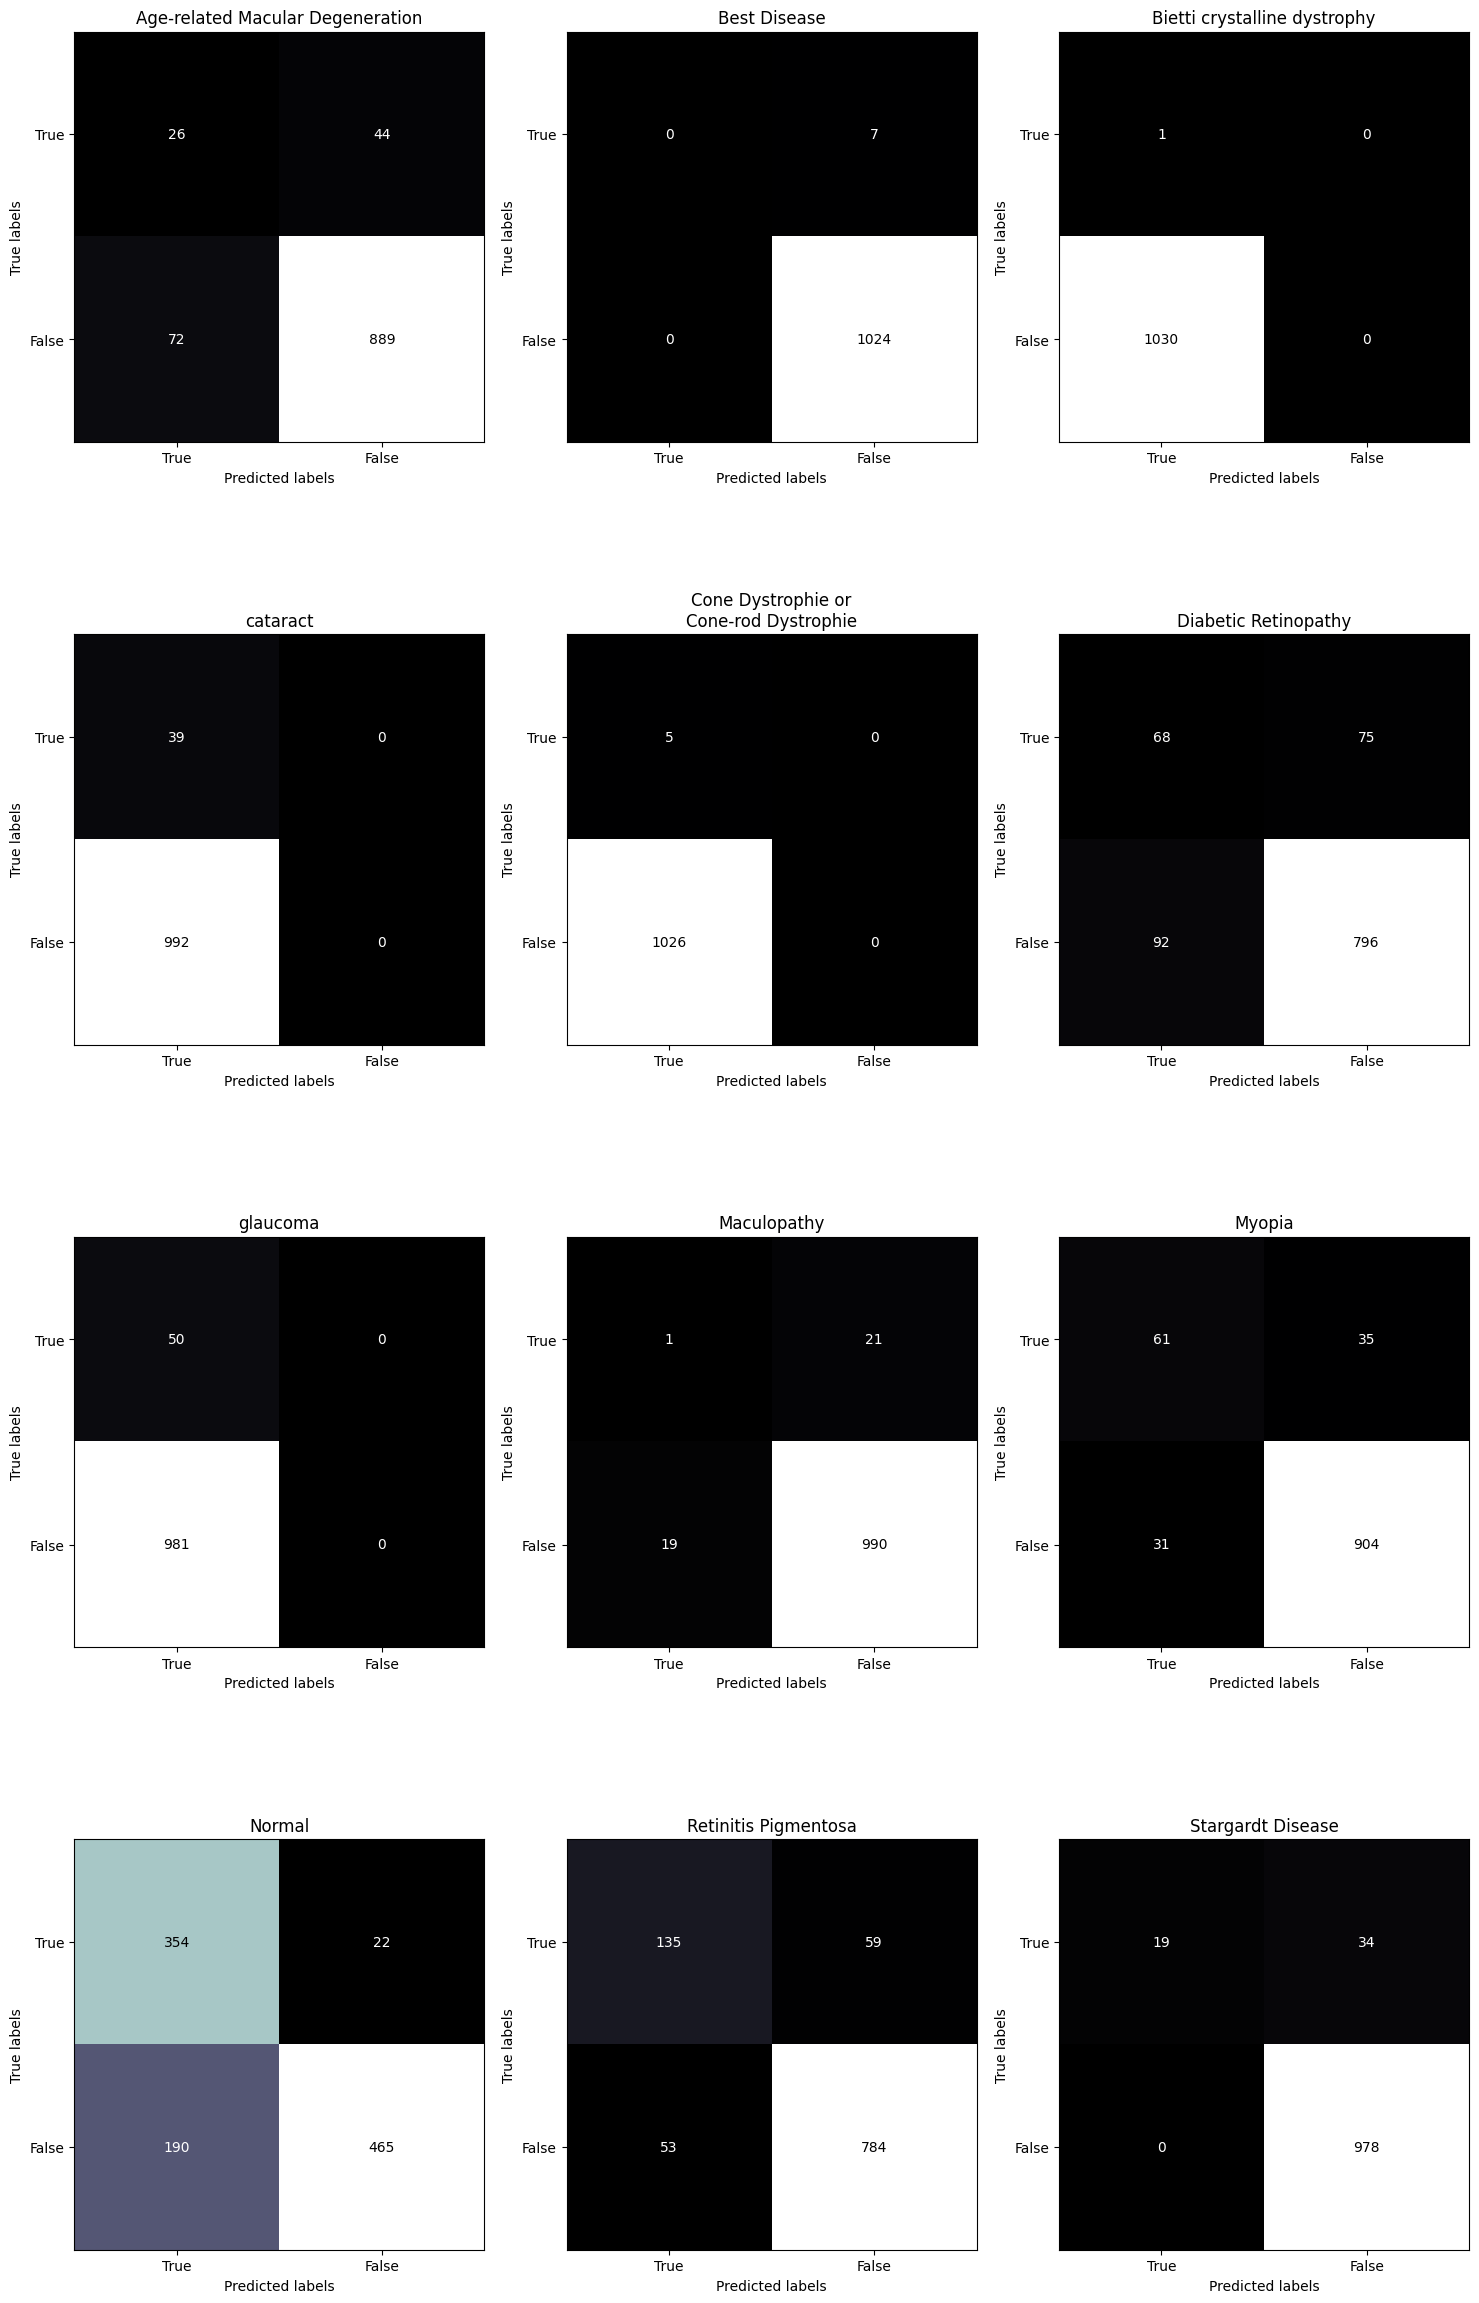

In [ ]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')